# Research Question 2: How did the performance treatments influence the relevant metrics of the Climate Superemulator?
## RQ 2.4:  What Number of workers results in the quickest Execution time while staying within the given memory requirements?

In [2]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
pip install jinja2

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
pip install scipy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
pip install pingouin

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [7]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import statistics


## Setup and Data Loading from Wandb

In [8]:
api = wandb.Api()

BS_Unet = api.runs(f"causalpaca/emulator", filters = {'group' : "NW_Unet"})
BatchSize_convlstm = api.runs(f"causalpaca/emulator", filters = {'group' : "NW_convlstm"})
BS_climax = api.runs(f"causalpaca/emulator", filters = {'group' : "NW_climax"})
BS_climax_frozen = api.runs(f"causalpaca/emulator", filters = {'group' : "NW_climax_frozen"})

occurrences = {}
occurrences_eval = {}
Treatment_Names = [0,2,4,8,16]

All_BS_Experiments = [BatchSize_convlstm,BS_Unet,BS_climax,BS_climax_frozen]
for experiment in All_BS_Experiments:
    for run in experiment:
        value = 0
        for i in Treatment_Names:
            if(f"{i}_Worker" in run.tags):
                value = i

        if value in occurrences:
            occurrences[value] += 1
        else:
            occurrences[value] = 1


print("Number of runs for each batchsize (test): ", occurrences)
counts = list(occurrences.values())
counts_eval = list(occurrences_eval.values())
# Checks if all batchsizes occur same often!
print("THIS SHOULD BE TRUE: ", all(count == counts[0] for count in counts))


    

Number of runs for each batchsize (test):  {16: 8, 8: 8, 4: 8, 2: 8, 0: 8}
THIS SHOULD BE TRUE:  True


In [9]:
def extract_parts_from_name(name):
    """
    Extracts parts from a given name.
    """
    parts = name.split('_')
    new_name = parts[1]
    if(parts[2]=="frozen"):
      new_name = new_name +"_"+ parts[2]
    return new_name

def filter_system_metrics(system_metrics, filter_criteria):
    """
    Filters system metrics based on specified criteria.
    """
    filtered_columns = [metric[0] for metric in filter_criteria]

    return system_metrics[filtered_columns]


data = []
for index, ml_model in enumerate(All_BS_Experiments):
  for run in ml_model:
      # Fetching metrics for the specified run
      try:
         name = run.config["model"]["model_name"]
      except: 
         name = run.config["model/model_name"]
      runtime_hours = run.summary["_wandb"].runtime / 60 / 60 # in minutes
      emissions = run.summary["emissions"]
      
      for i in Treatment_Names:
            if(f"{i}_Worker" in run.tags):
                nw = i
      # Retrieving system metrics history
      default_metrics = run.history(stream="default",pandas=True)
      train_time = default_metrics["time/train"].dropna().to_numpy()
      epoch = default_metrics["epoch"].dropna().to_numpy()
      accuracy = default_metrics["val/rmse"].dropna().to_numpy()
      
      system_metrics = run.history(stream="system",pandas=True)

      # print("defaul metrics\n")
      # print(model.scan_history())
      filter_criteria = [
          ['system.cpu'],
          ['system.gpu.process.0.gpu'],
          ['system.gpu.process.0.memoryAllocatedBytes'],
          ['system.proc.memory.rssMB'],
          ['system.memory']
      ]
      # Filtering system metrics based on the specified criteria
      system_metrics_filtered = filter_system_metrics(system_metrics, filter_criteria)

      # Create a new DataFrame for the current row
      data.append({
        "name": name,
        "Treatment": nw,
        "Time/Train": train_time,
        "CPU": system_metrics_filtered['system.cpu'].dropna().to_list(),
        "GPU": system_metrics_filtered['system.gpu.process.0.gpu'].dropna().to_list(),
        "GPU-Memory in GB": [x / (1e9) for x in system_metrics_filtered['system.gpu.process.0.memoryAllocatedBytes'].dropna().to_list()],
        "RSS-Memory in GB": [x / (1000) for x in system_metrics_filtered['system.proc.memory.rssMB'].dropna().to_list()],
        "RMSE": accuracy,
        "Epochs": epoch,
        "runtime_hours": runtime_hours,
        "Co2": emissions,
      })
      print(name, statistics.mean(train_time))


print(len(data))
# Convert the list of dictionaries to a DataFrame


convlstm 11.939453289243911
convlstm 8.756693792867136
convlstm 11.805010895152668
convlstm 9.23357109971099
convlstm 21.339218438326657
convlstm 15.947833264011075
convlstm 29.49436575366605
convlstm 42.63961669074165
convlstm 18.01351006825765
convlstm 17.390907742760398
unet 15.13581192970276
unet 24.818777875900267
unet 12.357284822463988
unet 13.49700686454773
unet 16.19504925727844
unet 10.70638349533081
unet 12.742094440460205
unet 11.99033169746399
unet 23.136271324157715
unet 27.77892635345459
climax 63.27870704650879
climax 63.687510833740234
climax 62.709475898742674
climax 75.96878885339808
climax 58.77240909576416
climax 79.31796714782715
climax 96.98737007141114
climax 67.17511310577393
climax 82.13435608485959
climax 66.29016143798827
climax_frozen 69.8691316986084
climax_frozen 75.52578273773193
climax_frozen 51.063135414123536
climax_frozen 50.53935276031494
climax_frozen 65.20766929626465
climax_frozen 72.04477123260499
climax_frozen 58.314024963378905
climax_frozen 6

In [10]:
runs_count = {}
for d in data:
    key = (d["name"], d["Treatment"])
    runs_count[key] = runs_count.get(key, 0) + 1
print(runs_count)

{('convlstm', 16): 2, ('convlstm', 8): 2, ('convlstm', 4): 2, ('convlstm', 2): 2, ('convlstm', 0): 2, ('unet', 2): 2, ('unet', 4): 2, ('unet', 0): 2, ('unet', 8): 2, ('unet', 16): 2, ('climax', 8): 2, ('climax', 16): 2, ('climax', 4): 2, ('climax', 2): 2, ('climax', 0): 2, ('climax_frozen', 16): 2, ('climax_frozen', 8): 2, ('climax_frozen', 4): 2, ('climax_frozen', 2): 2, ('climax_frozen', 0): 2}


In [11]:
# Merge the Multiples
mean_data = {}


for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]),0)
    print(number_runs)
    print()
    print(run[0],run[1])
    CPU_Lists=[]
    GPU_Lists=[]
    RSS_Lists=[]
    RMSE_Lists=[]
    Steps_Lists=[]
    Runtime_Lists=[]
    CO2_Lists=[]
    Time_train_list = []
    GPU_Mem_List = []
    for d in data: 
        if d["name"] == run[0] and d["Treatment"] == run[1]:
            CPU_Lists.append(d["CPU"])
            GPU_Lists.append(d["GPU"])
            RSS_Lists.append(d["RSS-Memory in GB"])
            GPU_Mem_List.append(d["GPU-Memory in GB"])
            RMSE_Lists.append(d["RMSE"])
            Steps_Lists.append(d["Epochs"])
            Runtime_Lists.append(d["runtime_hours"])
            CO2_Lists.append(d["Co2"])
            Time_train_list.append(d["Time/Train"])

    print(len([(x + y)/2 for x, y in zip(RMSE_Lists[0], RMSE_Lists[1])]))


    if (number_runs>=2):
        mean_data[(run[0], run[1])] = {
            "CPU": [(x + y)/2 for x, y in zip(CPU_Lists[0], CPU_Lists[1])],
            "time/train": [(x + y)/2 for x, y in zip(Time_train_list[0], Time_train_list[1])],
            "GPU": [(x + y)/2 for x, y in zip(GPU_Lists[0], GPU_Lists[1])],
            "RSS-Memory in GB": [(x + y)/2 for x, y in zip(RSS_Lists[0], RSS_Lists[1])],
            "GPU-Memory in GB":[(x + y)/2 for x, y in zip(GPU_Mem_List[0], GPU_Mem_List[1])],
            "RMSE": [(x + y)/2 for x, y in zip(RMSE_Lists[0], RMSE_Lists[1])],
            "Epochs": [(x + y)/2 for x, y in zip(Steps_Lists[0], Steps_Lists[1])],
            "runtime_hours": statistics.mean(Runtime_Lists),
            "Co2": statistics.mean(CO2_Lists)
        }
    else:
        print("skipped")

print(mean_data)

2

convlstm 16
91
2

convlstm 8
91
2

convlstm 4
89
2

convlstm 2
91
2

convlstm 0
90
2

unet 2
100
2

unet 4
100
2

unet 0
100
2

unet 8
100
2

unet 16
100
2

climax 8
100
2

climax 16
100
2

climax 4
100
2

climax 2
55
2

climax 0
100
2

climax_frozen 16
100
2

climax_frozen 8
100
2

climax_frozen 4
100
2

climax_frozen 2
100
2

climax_frozen 0
100
{('convlstm', 16): {'CPU': [0.24, 0.455, 0.455, 0.31, 0.245, 0.24, 0.235, 0.25, 0.265, 0.24, 0.245, 0.26, 0.245, 0.235, 0.265, 0.25, 0.24, 0.26, 0.265, 0.245, 0.26, 0.27999999999999997, 0.22999999999999998, 0.25, 0.36, 0.44, 0.45, 0.45, 0.445, 0.45999999999999996, 0.455, 0.445, 0.44999999999999996, 0.47, 0.435, 0.44499999999999995, 0.45, 0.44999999999999996, 0.435, 0.475, 0.44, 0.43], 'time/train': [9.88901138305664, 7.146017074584961, 10.780410766601562, 10.059417724609375, 9.267909526824951, 11.361793041229248, 14.299190044403076, 324.177668094635, 6.662374258041382, 7.322930812835693, 10.668844223022461, 7.724005222320557, 7.86487483978

## Overview of Mean, Median and STD

In [12]:
import math

data_scheme={
    "CPU": [(x + y)/2 for x, y in zip(CPU_Lists[0], CPU_Lists[1])],
    "time/train": [(x + y)/2 for x, y in zip(Time_train_list[0], Time_train_list[1])],
    "GPU": [(x + y)/2 for x, y in zip(GPU_Lists[0], GPU_Lists[1])],
    "RSS-Memory in GB": [(x + y)/2 for x, y in zip(RSS_Lists[0], RSS_Lists[1])],
    "RMSE": [(x + y)/2 for x, y in zip(RMSE_Lists[0], RMSE_Lists[1])],
    "Epochs": [(x + y)/2 for x, y in zip(Steps_Lists[0], Steps_Lists[1])],
    "runtime_minutes": statistics.mean(Runtime_Lists),
    "Co2": statistics.mean(CO2_Lists)
}


rows = []
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]),0)
    if(number_runs>=2):
        name = run[0]
        treatment = run[1]
        data_for_run = mean_data.get((run[0], run[1]),0)
        new_row = {
            "Name":name, 
            "Treatment":treatment, 
            "CPU_Mean": statistics.mean(data_for_run["CPU"]), 
            "CPU_Median": statistics.median(data_for_run["CPU"]), 
            "CPU_STD": statistics.stdev(data_for_run["CPU"]), 
            "GPU_Mean": statistics.mean(data_for_run["GPU"]), 
            "GPU_Median": statistics.median(data_for_run["GPU"]), 
            "GPU_STD": statistics.stdev(data_for_run["GPU"]), 
            "Time/Train Mean_Minutes": statistics.mean(data_for_run["time/train"])/60,
            "Time/Train Median_Minutes": statistics.median(data_for_run["time/train"])/60,
            "Time/Train STD_Minutes": statistics.stdev(data_for_run["time/train"])/60,
            "RSS-Memory_Mean": statistics.mean(data_for_run["RSS-Memory in GB"]), 
            "GPU-Memory_Mean": statistics.mean(data_for_run["GPU-Memory in GB"]), 
            "RSS-Memory_Median": statistics.median(data_for_run["RSS-Memory in GB"]), 
            "RSS-Memory_STD": statistics.stdev(data_for_run["RSS-Memory in GB"]), 
            "RMSE": min(data_for_run["RMSE"]), 
            "Min_RMSE": min(data_for_run["RMSE"]), 
            "runtime_hours": data_for_run["runtime_hours"], 
            "Co2": data_for_run["Co2"]}
        
        rows.append(new_row)

new_df = pd.DataFrame(rows)
finalized_data = new_df.sort_values(by='Treatment')
finalized_data = new_df.sort_values(by=['Name','Treatment'])
def round_if_float(x):
    if isinstance(x, float):
        rounded_value = round(x, 3)
        return rounded_value
    return x
finalized_data = finalized_data.applymap(round_if_float)
selected_columns = ['Name', 'Treatment',"CPU_Mean","GPU_Mean","RSS-Memory_Mean","GPU-Memory_Mean","runtime_hours"]
selected_column = ['Name', 'Treatment',"Time/Train Mean_Minutes"]

new_df = finalized_data[selected_columns].copy()

latex_table = new_df.to_latex(index=False,float_format="%.3f")
smaller_table = new_df.to_latex(index=False,float_format="%.3f")

print(latex_table)

#print(smaller_table)



\begin{tabular}{lrrrrrr}
\toprule
Name & Treatment & CPU_Mean & GPU_Mean & RSS-Memory_Mean & GPU-Memory_Mean & runtime_hours \\
\midrule
climax & 0 & 0.429 & 13.176 & 25.895 & 7.916 & 1.766 \\
climax & 2 & 0.419 & 28.775 & 21.841 & 5.042 & 2.228 \\
climax & 4 & 0.410 & 11.067 & 24.978 & 7.884 & 2.289 \\
climax & 8 & 0.416 & 12.608 & 26.390 & 7.830 & 1.866 \\
climax & 16 & 0.405 & 11.462 & 27.570 & 7.758 & 2.079 \\
climax_frozen & 0 & 0.506 & 10.805 & 23.854 & 5.595 & 1.711 \\
climax_frozen & 2 & 0.403 & 11.731 & 24.892 & 5.563 & 1.562 \\
climax_frozen & 4 & 0.414 & 11.310 & 24.909 & 5.559 & 1.676 \\
climax_frozen & 8 & 0.418 & 10.539 & 25.226 & 5.608 & 1.910 \\
climax_frozen & 16 & 0.384 & 9.103 & 24.898 & 5.568 & 2.052 \\
convlstm & 0 & 0.719 & 12.385 & 11.462 & 2.058 & 0.527 \\
convlstm & 2 & 0.458 & 24.875 & 11.491 & 1.926 & 0.410 \\
convlstm & 4 & 0.370 & 13.684 & 11.627 & 1.926 & 0.765 \\
convlstm & 8 & 0.329 & 15.164 & 11.916 & 1.914 & 0.544 \\
convlstm & 16 & 0.344 & 16.248 & 12

C:\Users\fe-na\AppData\Local\Temp\ipykernel_29140\1434898958.py:53: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  finalized_data = finalized_data.applymap(round_if_float)


In [30]:

filtered_df = finalized_data[((finalized_data['Name'] == 'climax') & (finalized_data['Treatment'] == 8)) |
                 ((finalized_data['Name'] == 'climax') & (finalized_data['Treatment'] == 0)) |
                 ((finalized_data['Name'] == 'climax_frozen') & (finalized_data['Treatment'] == 2)) |
                 ((finalized_data['Name'] == 'climax_frozen') & (finalized_data['Treatment'] == 0)) |
                 ((finalized_data['Name'] == 'convlstm') & (finalized_data['Treatment'] == 2)) |
                 ((finalized_data['Name'] == 'convlstm') & (finalized_data['Treatment'] == 0)) |
                 ((finalized_data['Name'] == 'unet') & (finalized_data['Treatment'] == 2)) |
                 ((finalized_data['Name'] == 'unet') & (finalized_data['Treatment'] == 0))]
selected_columns_df = filtered_df[['Time/Train Mean_Minutes', 'Name', 'Treatment', 'RSS-Memory_Mean', "runtime_hours"]].reset_index(drop=True)


print(selected_columns_df)

   Time/Train Mean_Minutes           Name  Treatment  RSS-Memory_Mean  \
0                    1.042         climax          0           25.895   
1                    1.087         climax          8           26.390   
2                    1.017  climax_frozen          0           23.854   
3                    0.918  climax_frozen          2           24.892   
4                    0.327       convlstm          0           11.462   
5                    0.227       convlstm          2           11.491   
6                    0.203           unet          0            9.743   
7                    0.215           unet          2            9.926   

   runtime_hours  
0          1.766  
1          1.866  
2          1.711  
3          1.562  
4          0.527  
5          0.410  
6          0.393  
7          0.398  


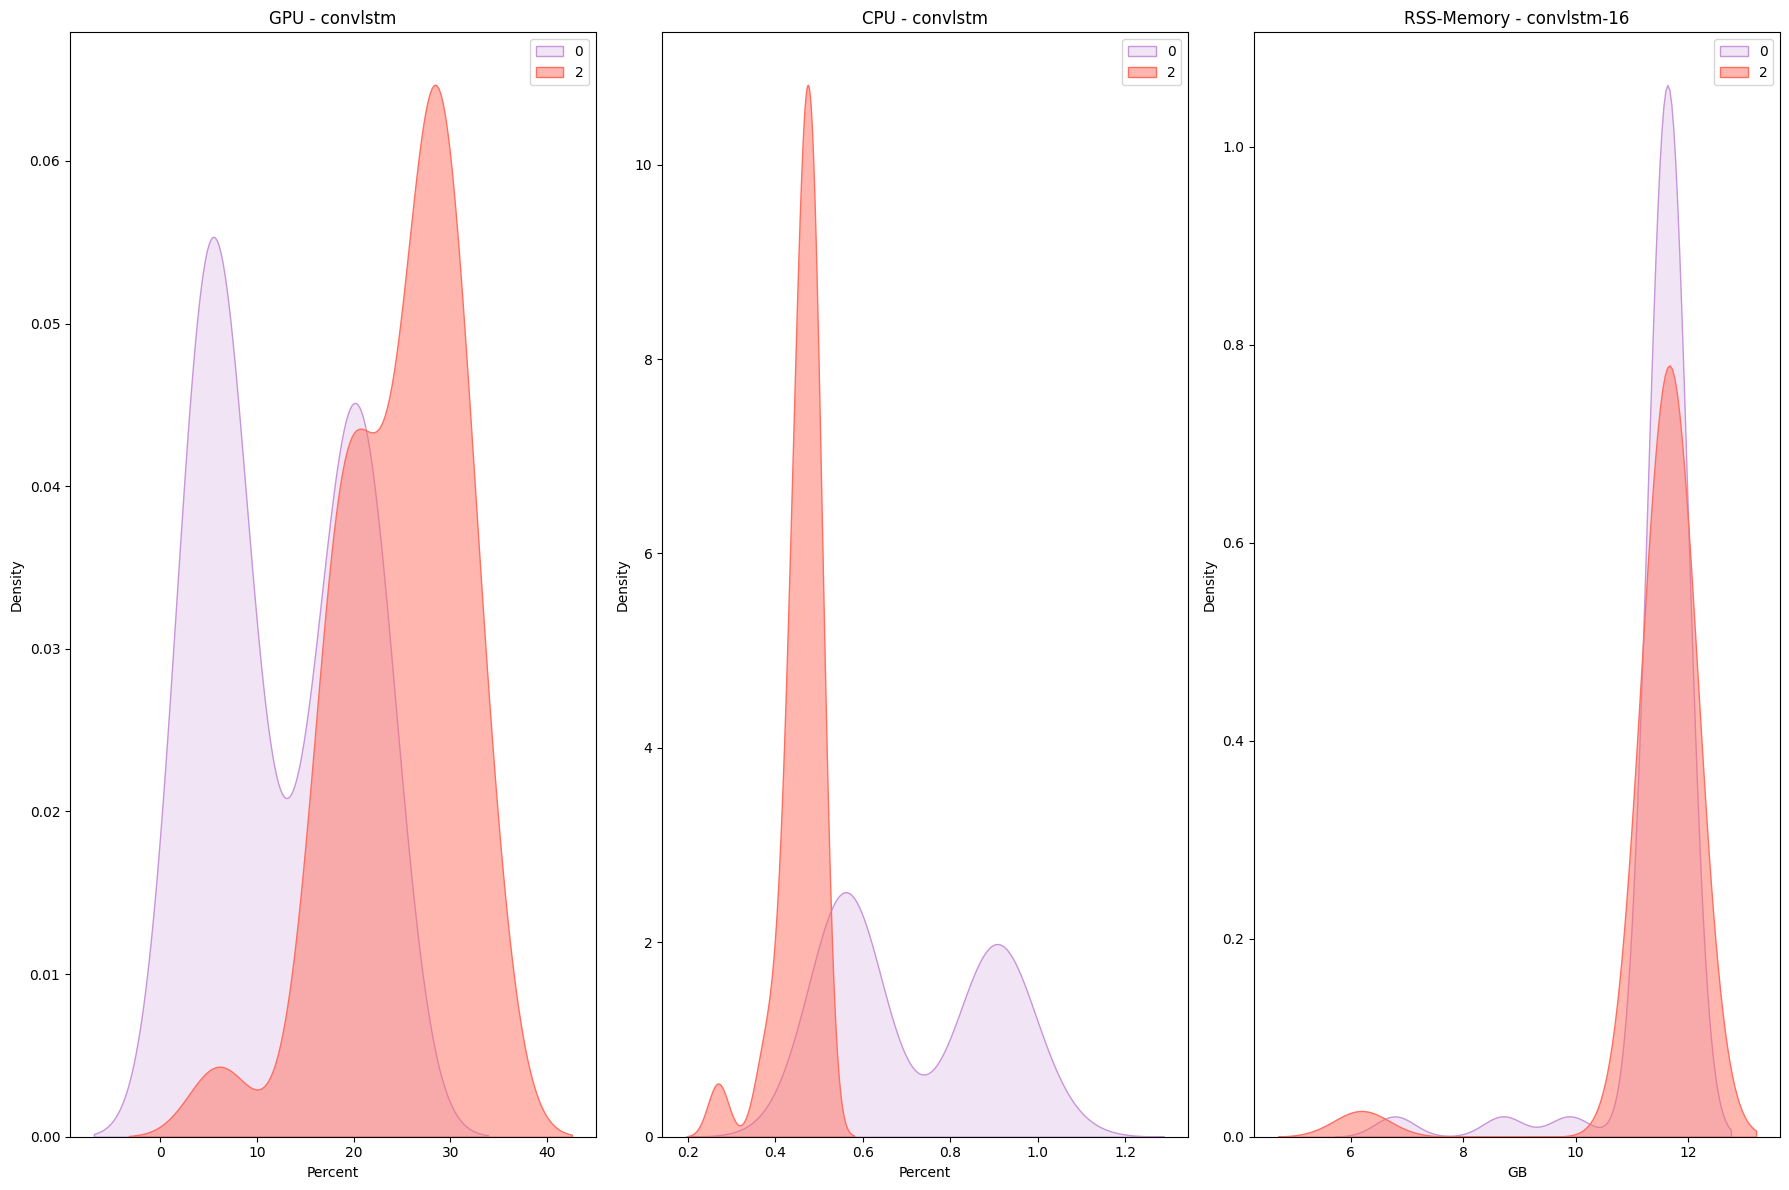

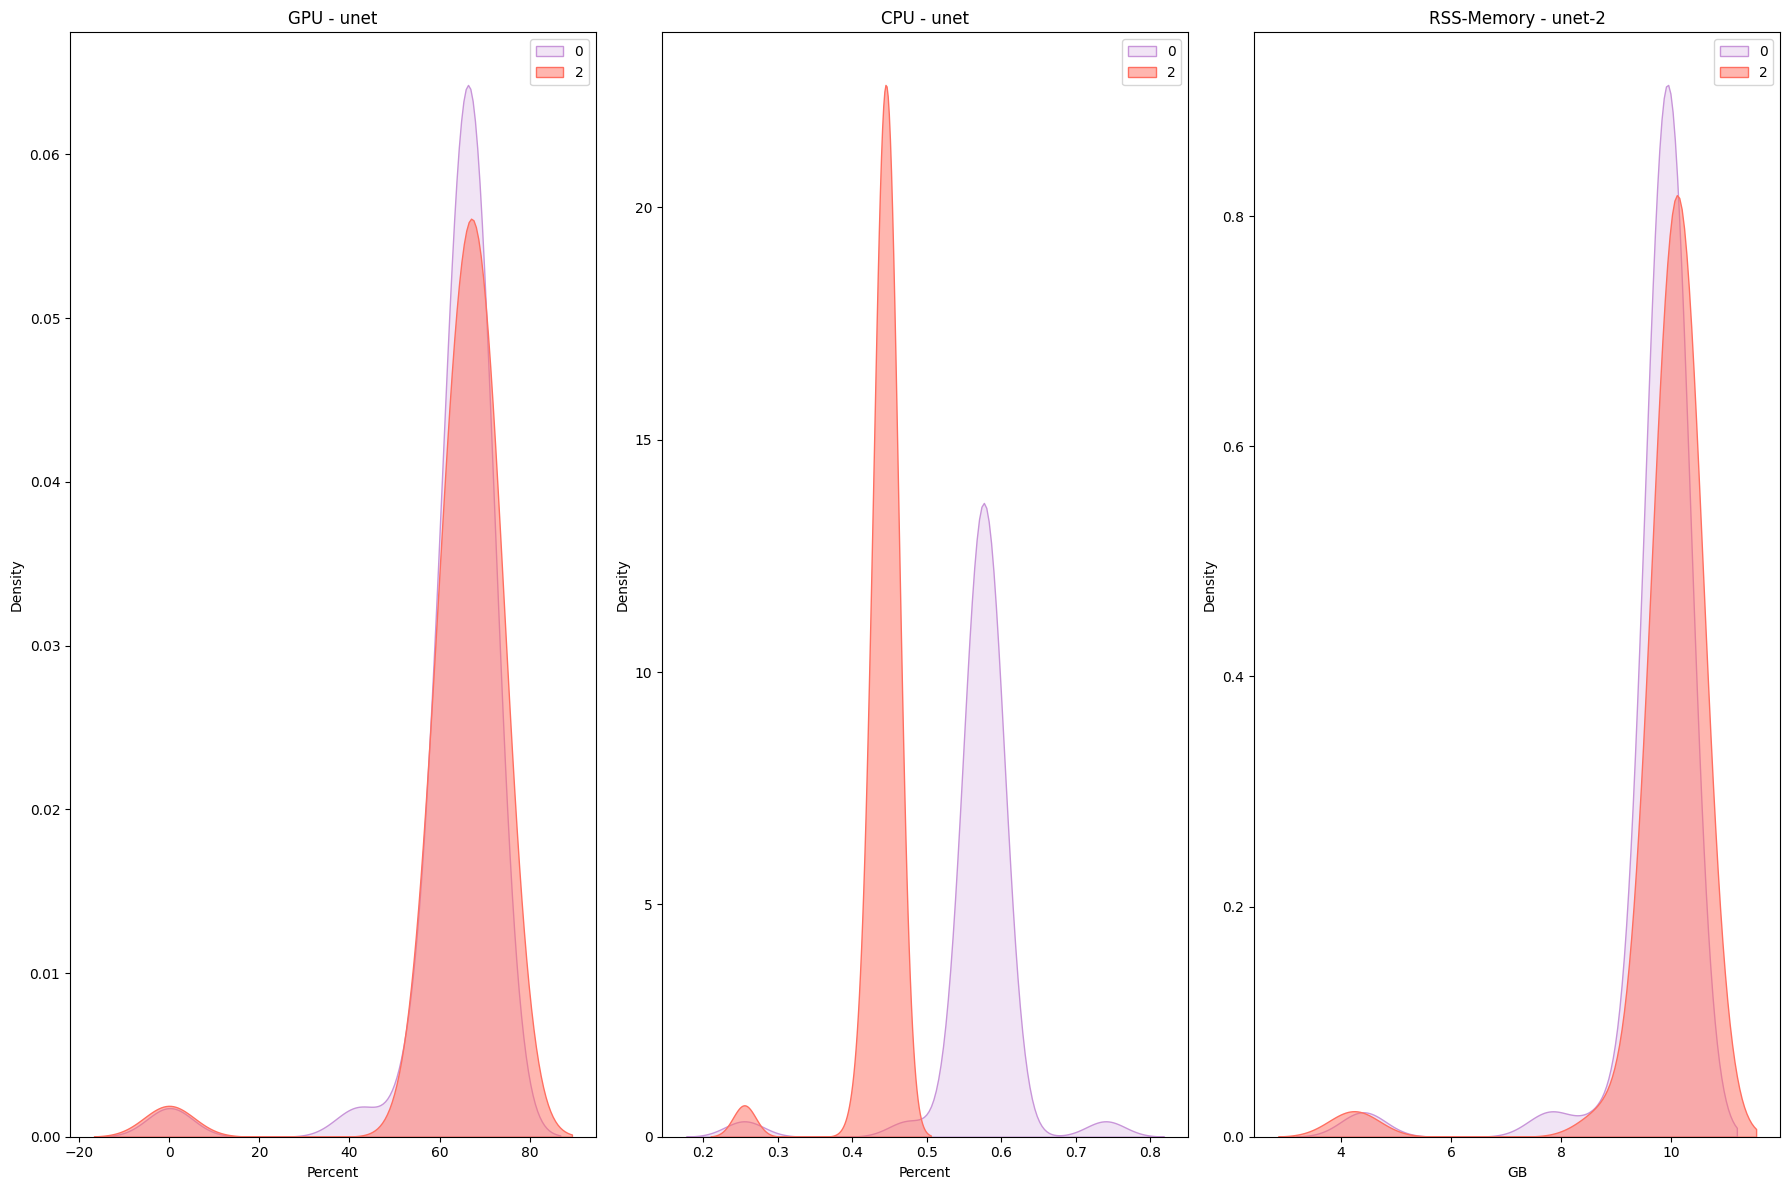

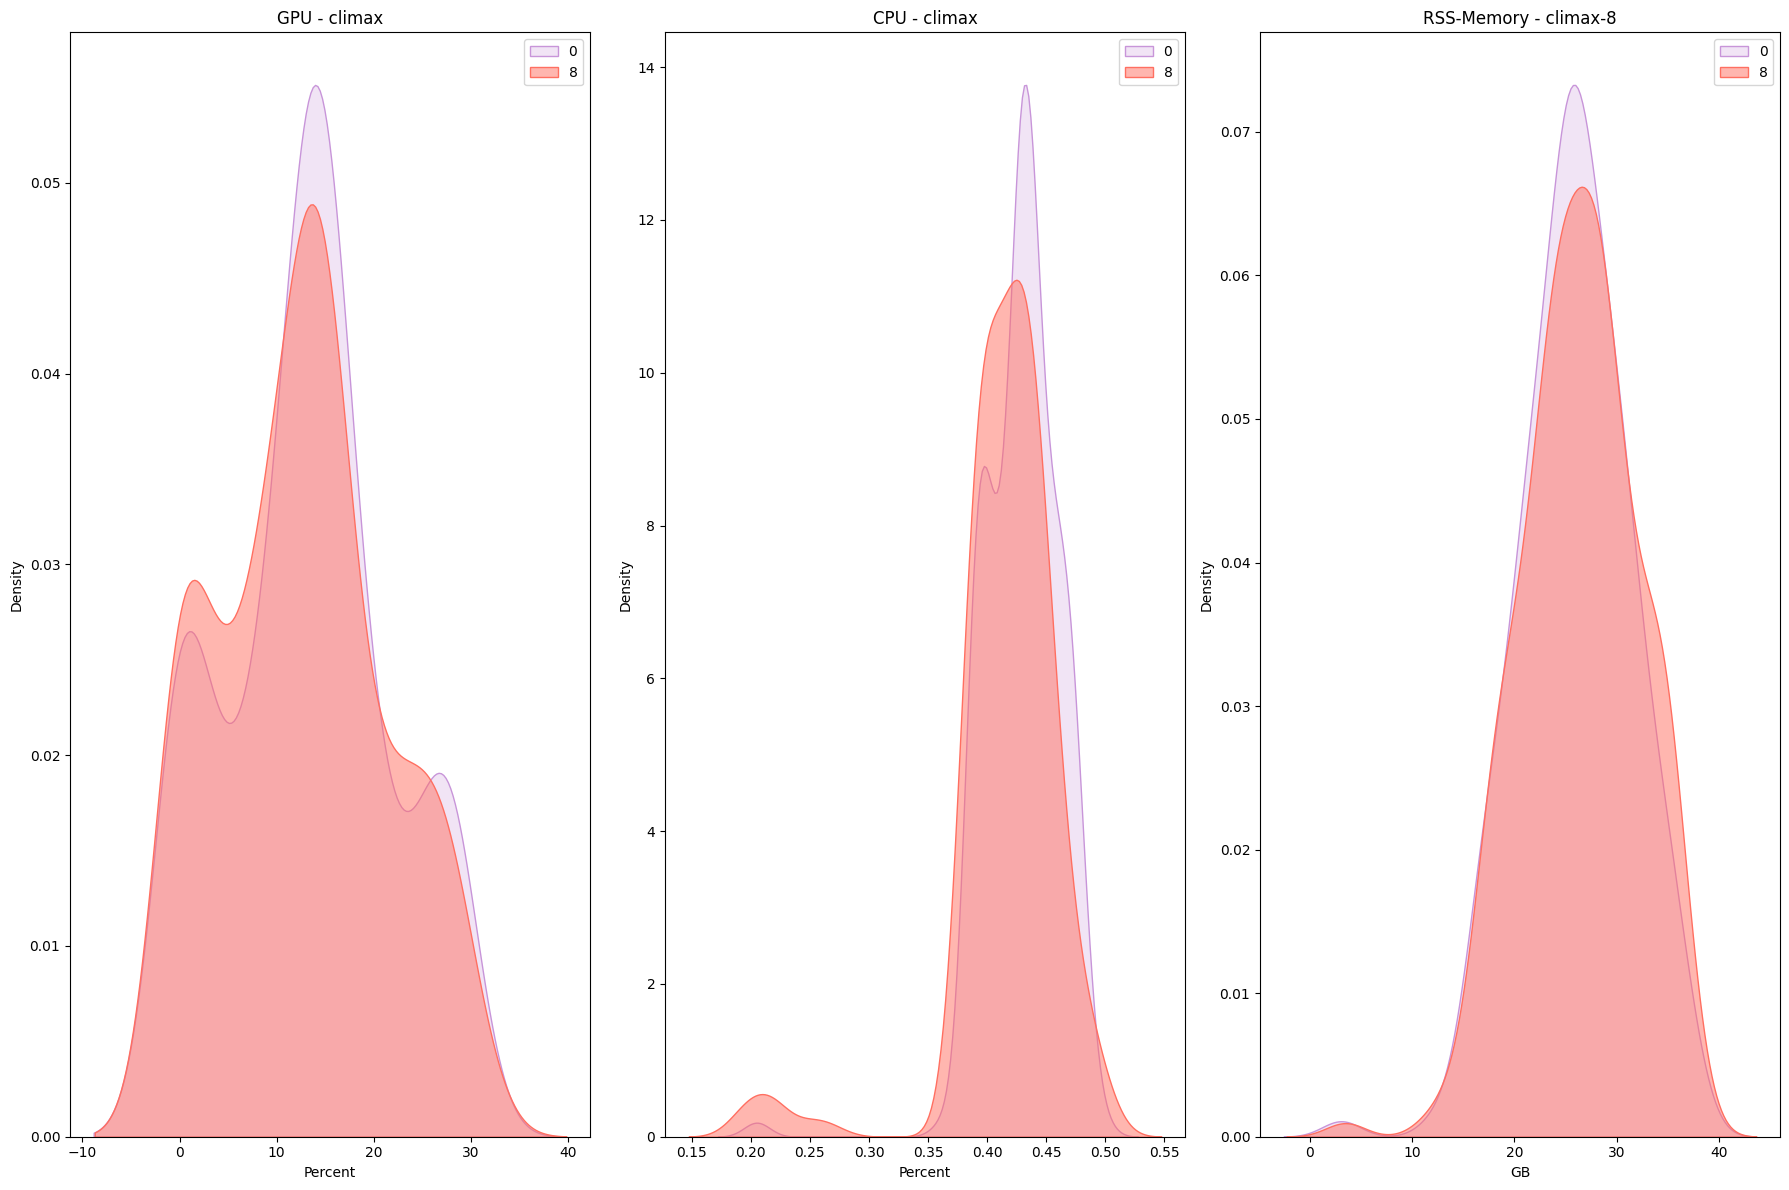

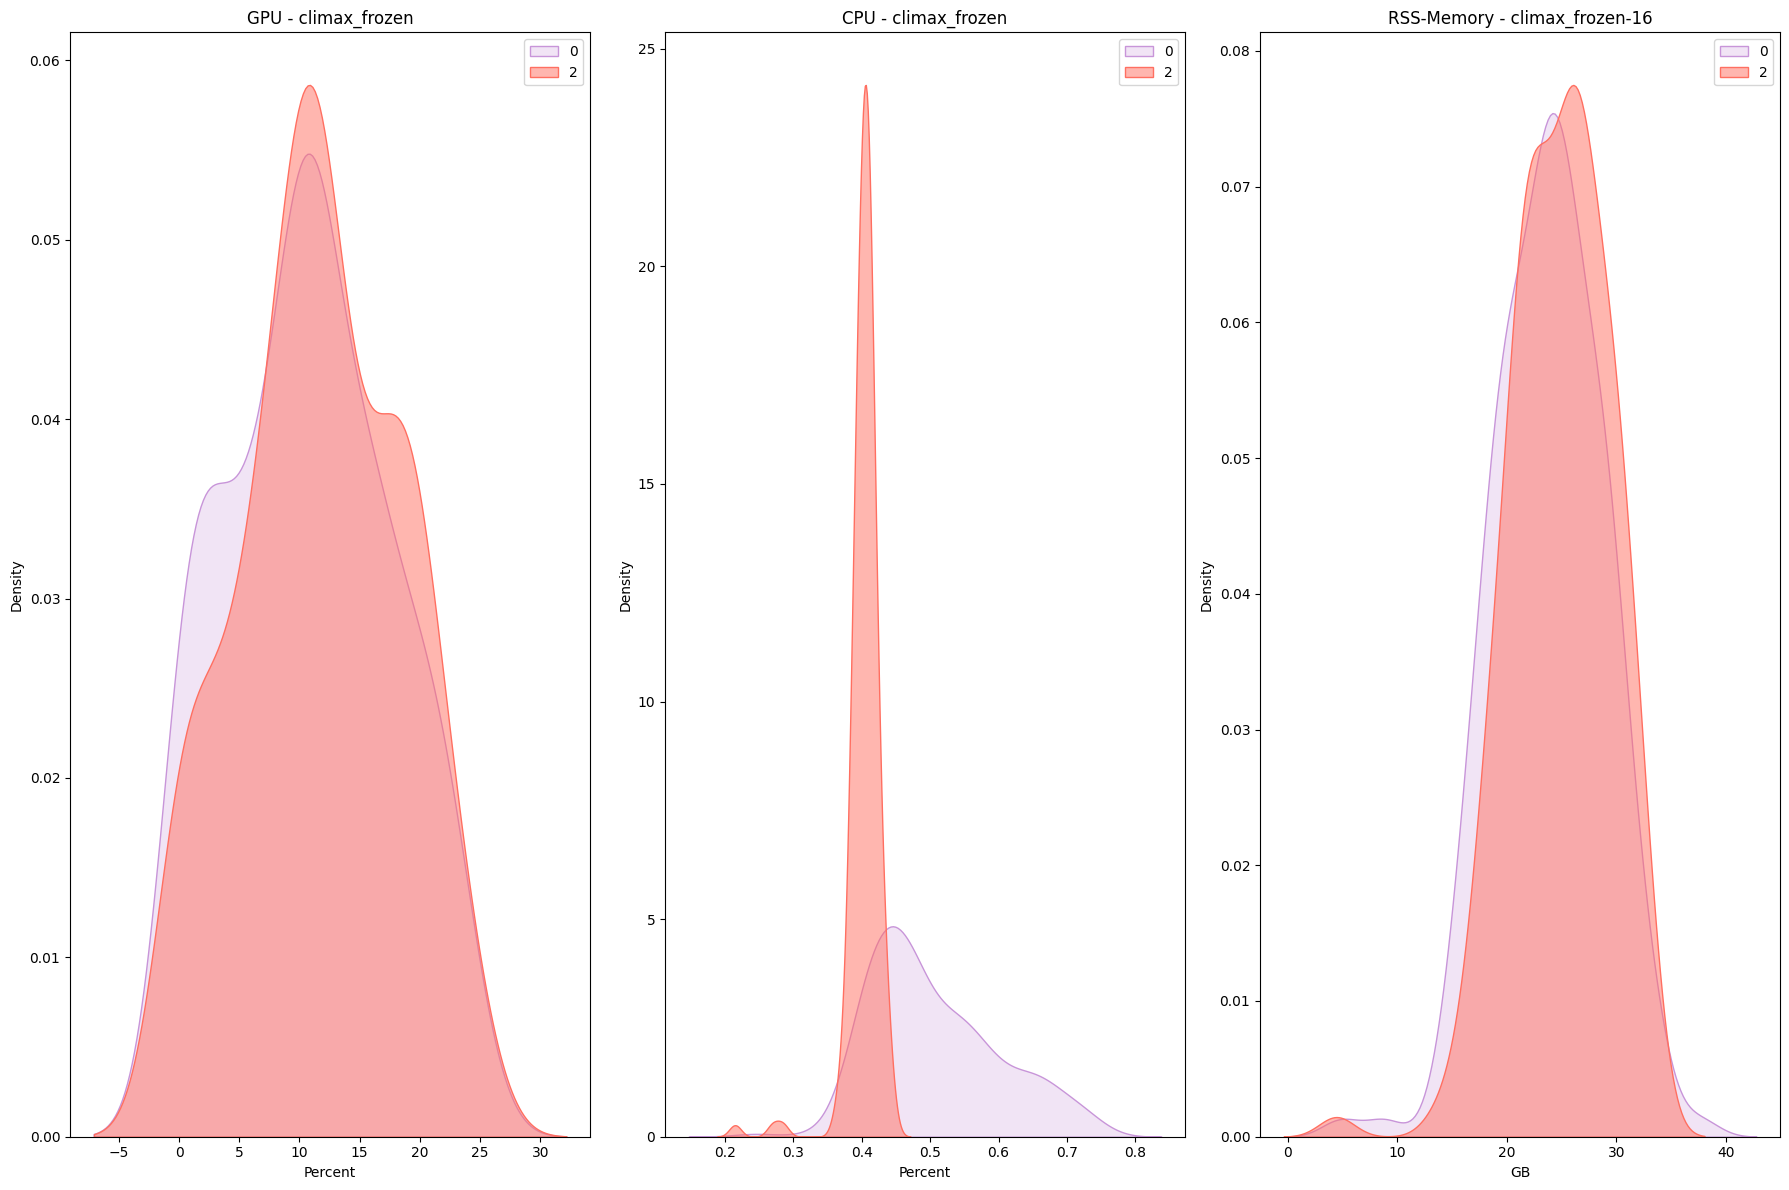

In [31]:
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from seaborn_qqplot import pplot
from scipy.stats import gamma
from PIL import Image
import statsmodels.api as sm 
import pylab as py 



def violin_plot(ax, data, name, unit):
    sns.violinplot(data=data, ax=ax, inner="box", color="#c895d9")
    ax.set_title(name)
    ax.set_xlabel("Data Distribution")
    ax.set_ylabel(unit)

def density_plot(ax, data, name, unit):
    sns.kdeplot(data=data, fill=True, color="#c895d9", ax=ax)
    ax.set_title(name)
    ax.set_xlabel(unit)
    ax.set_ylabel("Density")


def qq_plot(ax, data, name, line_color="#c895d9"):
    # multirow = [{"Theoretical_Quantiles":np.array((stats.norm.ppf(np.arange(1, len(data)+1) / (len(data)+1))),dtype=float), "species":0}]
    # df = pd.DataFrame(multirow)
    # df_new = df.explode("Theoretical_Quantiles").astype(float)
    # # Plot the quantiles
    # pairGrid = pplot(df_new, x="Theoretical_Quantiles",y=gamma, kind='qq', height=5, aspect=1, display_kws={"identity":False, "fit":True, "reg":True, "ci":0.025})
    # pairGrid.add_legend(title=name)
    # pairGrid.figure.savefig(f"figures/{name}")
    # sm.qqplot(np.array(data), line ='45') 
    pp = sm.ProbPlot(np.array(data), fit=True)
    qq = pp.qqplot(ax=ax, marker='.', markerfacecolor='k', alpha=0.3, color='#1f77b4')
    sm.qqline(ax=ax, line='45', fmt='k--')
    ax.set_title(name)
    
    

def density_plot_2(ax, treatment_0, treatment_1,name_0,name_1, name, unit):
    sns.kdeplot(data=treatment_0, fill=True, color="#c895d9", ax=ax, label=name_0)
    sns.kdeplot(data=treatment_1, fill=True, color="#ff6f61", ax=ax, alpha=0.5, label=name_1)
    ax.set_title(name)
    ax.set_xlabel(unit)
    ax.set_ylabel("Density")
    ax.legend()

def scale_down(data,factor=6.0):
    new_data = []
    for x in data:
        new_x = x / factor
        new_data.append(new_x)
    return new_data
        

############################################ VIOLIN & DENSITY PLOTS ############################################################

# for run in runs_count: 
#     number_runs = runs_count.get((run[0], run[1]), 0)
#     if number_runs >= 2:
#         name = run[0]
#         treatment = run[1]
#         data_for_run = mean_data.get((run[0], run[1]), 0)
        
#         fig, axes = plt.subplots(1, 2, figsize=(18, 12))  # Create a 2x3 grid of subplots
#         if(run[1] != "Baseline"): 
#             violin_plot(axes[0], data_for_run["GPU"], f"GPU - {run[0]}-{run[1]}", "Percent")
#             # violin_plot(axes[0, 1], data_for_run["CPU"], f"CPU - {run[0]}-{run[1]}", "Percent")
#             # violin_plot(axes[0, 2], data_for_run["RSS-Memory in GB"], f"RSS-Memory - {run[0]}-{run[1]}", "GB")
            
#             density_plot(axes[1], data_for_run["GPU"], f"GPU - {run[0]}-{run[1]}", "Percent")
#             # density_plot(axes[1, 1], data_for_run["CPU"], f"CPU - {run[0]}-{run[1]}", "Percent")
#             # density_plot(axes[1, 2], data_for_run["RSS-Memory in GB"], f"RSS-Memory - {run[0]}-{run[1]}", "GB")
            
#             plt.tight_layout()
#             fig.savefig(f"figures/RQ_2.3_violin_density/RQ_2.3_violin_density_{name}-{treatment}.png")    

############################################ QQ PLOTS ############################################################
# for run in runs_count: 
#     number_runs = runs_count.get((run[0], run[1]), 0)
#     if number_runs >= 2:
#         name = run[0]
#         treatment = run[1]
#         data_for_run = mean_data.get((run[0], run[1]), 0)

#         fig, axes = plt.subplots(1, 1, figsize=(15, 5),)  # Create a 2x3 grid of subplots
#         if(run[1] != "Baseline"): 
#             qq_plot(axes,data_for_run["GPU"], f"GPU - {run[0]}-{run[1]}")
#             # qq_plot(axes[1],data_for_run["CPU"], f"CPU - {run[0]}-{run[1]}")
#             # qq_plot(axes[2],data_for_run["RSS-Memory in GB"], f"RSS-Memory - {run[0]}-{run[1]}")

#             fig.savefig(f"figures/RQ_2.2_QQ/RQ_2_QQ_{name}-{treatment}")        
         # will now save all plots

############################################ COMBINED DENSITY PLOTS ############################################################

mappings = {"climax": 8, "climax_frozen": 2, "convlstm": 2, "unet": 2}
already_used_name=[]
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if(number_runs >= 2 and (run[0] not in already_used_name)):
        already_used_name.append(run[0])
        name = run[0]
        treatment = run[1]
        treatment_0 = Treatment_Names[0]
        treatment_1 = mappings[name]


        data_for_run_0 = mean_data.get((run[0], treatment_0), 0)
        data_for_run_1 = mean_data.get((run[0], treatment_1), 0)

        

        fig, axes = plt.subplots(1, 3, figsize=(18, 12))  # Create a 2x3 grid of subplots

        density_plot_2(axes[0], data_for_run_0["GPU"],data_for_run_1["GPU"],treatment_0,treatment_1, f"GPU - {run[0]}", "Percent")
        density_plot_2(axes[1], data_for_run_0["CPU"],data_for_run_1["CPU"],treatment_0,treatment_1, f"CPU - {run[0]}", "Percent")
        density_plot_2(axes[2], data_for_run_0["RSS-Memory in GB"],data_for_run_1["RSS-Memory in GB"],treatment_0,treatment_1, f"RSS-Memory - {run[0]}-{run[1]}", "GB")
        
        plt.tight_layout()
        fig.savefig(f"figures/RQ_2.5_combined_density/{name}-{treatment_1}.png")        





convlstm 0
convlstm 2
55 31
55 55


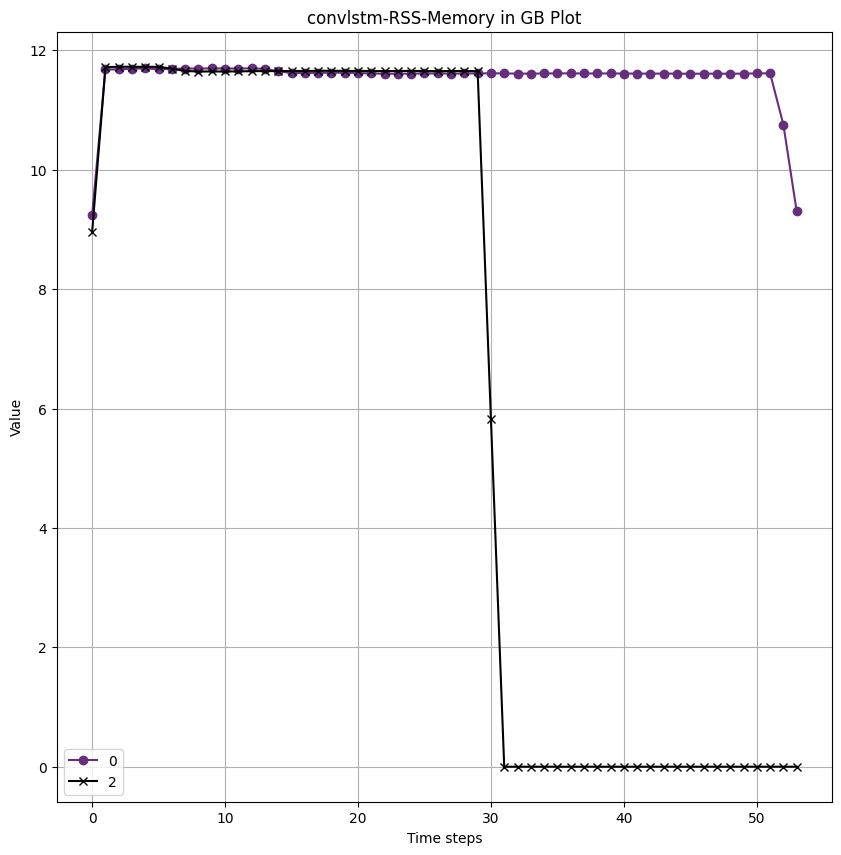

623.3690583333333 352.0735883333333
unet 0
unet 2
46 39
46 46


C:\Users\fe-na\AppData\Local\Temp\ipykernel_29140\3532277647.py:63: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  integral = scipy.integrate.simps(arr, x=None, dx=1,axis=-1, even='avg')


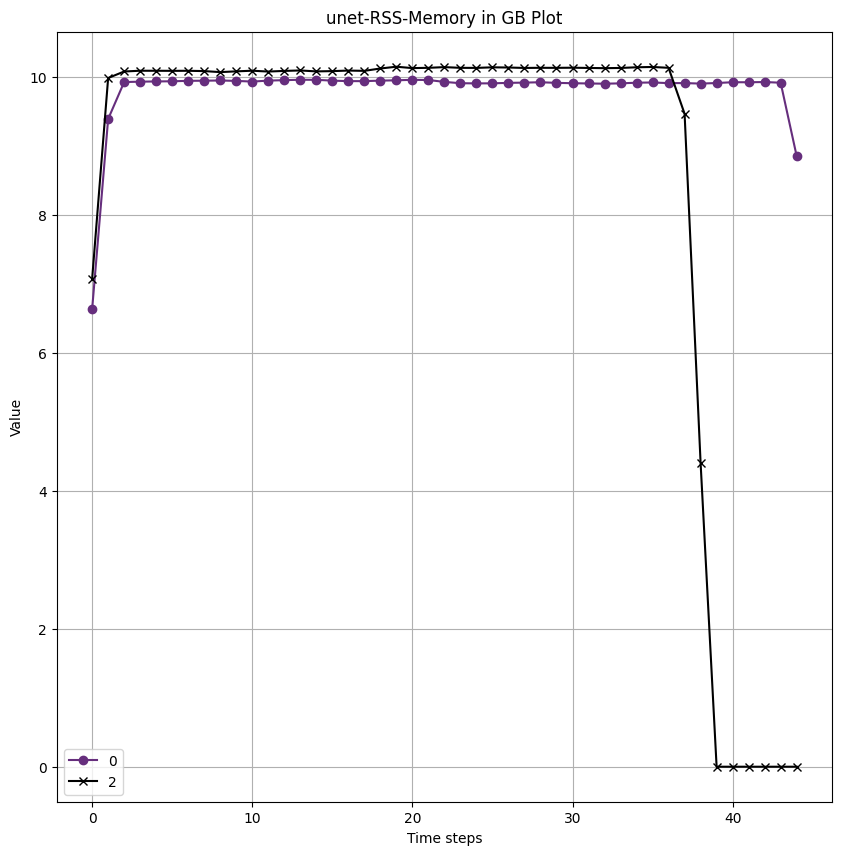

442.5980266666666 385.4588591666666
climax 0
climax 8
197 219
219 219


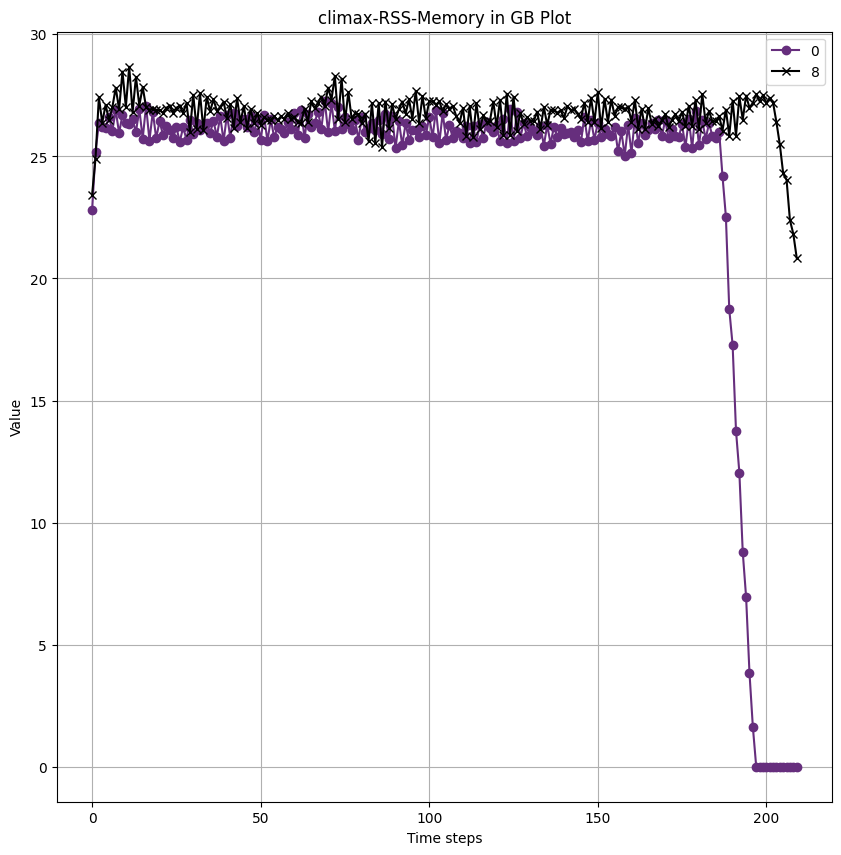

5126.709599999999 5784.397851666666
climax_frozen 0
climax_frozen 2
191 171
191 191


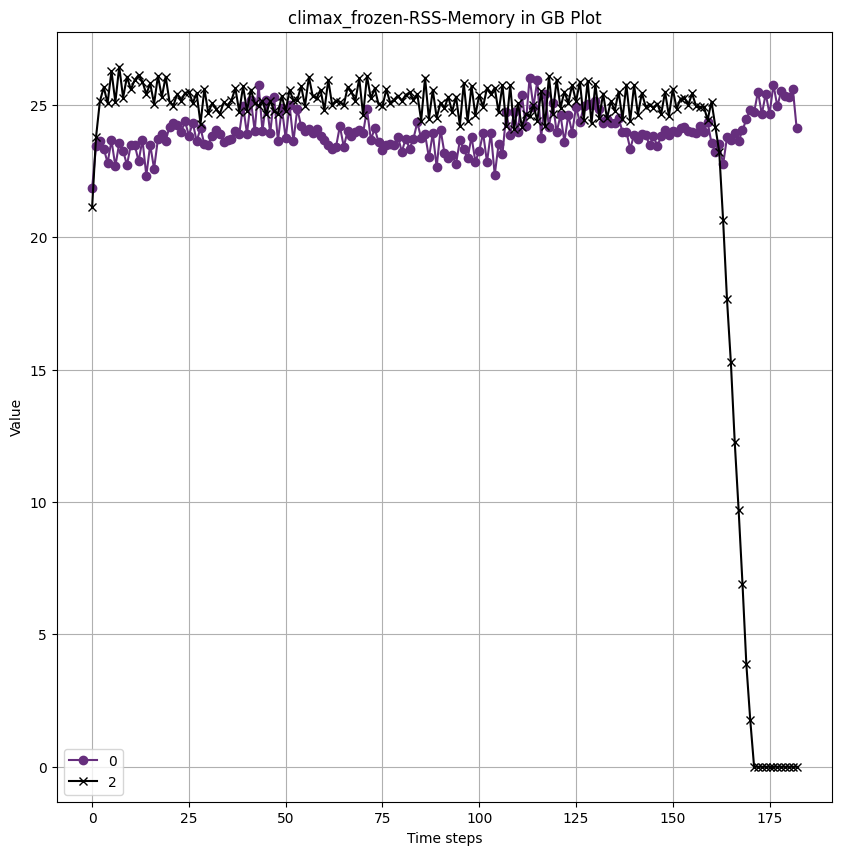

4606.219571666666 4202.243408333333


In [32]:

from scipy import stats
import scipy
import matplotlib.patches as mpatches

keyword = "RSS-Memory in GB"
#keyword = "GPU_Memory in GB"

unit = "GB"


def smooth_array(array, factor=0.05):
    """
    Applies a moving average to smooth the array.

    Parameters:
    array (list or np.array): The array to smooth.
    factor (float): The smoothing factor. Determines the window size.

    Returns:
    np.array: The smoothed array.
    """
    window_size = int(len(array) * factor)
    if window_size < 1:
        window_size = 1
    smoothed_array = np.convolve(array, np.ones(window_size)/window_size, mode='valid')
    return smoothed_array

def plot_arrays(array1, array2, label_1='Array 1', label_2='Array 2', title="Plot", unit="value"):
    """
    Plots two smoothed arrays on a single diagram with a purple and black color scheme.

    Parameters:
    array1 (list or np.array): The first array to plot.
    array2 (list or np.array): The second array to plot.
    label_1 (str): Label for the first array.
    label_2 (str): Label for the second array.

    Returns:
    None
    """
    smoothed_array1 = smooth_array(array1)
    smoothed_array2 = smooth_array(array2)

    plt.figure(figsize=(10, 10))
    title = title.replace("GB", "GB")

    plt.plot(smoothed_array1, label=label_1, marker='o', color='#662E7D')
    plt.plot(smoothed_array2, label=label_2, marker='x', color='black')

    plt.xlabel('Time steps')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"figures/RQ_2.3/{title}.png")
    plt.show()

def integral_below_curve(arr):
    # Calculate the width of each interval
    dx = 1  # Assuming the intervals are of unit width

    # Use the trapezoidal rule for numerical integration
    integral = scipy.integrate.simps(arr, x=None, dx=1,axis=-1, even='avg')
    #integral = np.trapz(arr, dx=dx)
    return integral

mappings = {"climax": 8, "climax_frozen": 2, "convlstm": 2, "unet": 2}

data_list_rank_sum = []
already_used_name=[]
arr_of_integrals = []
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if(number_runs >= 2 and (run[0] not in already_used_name)):
        already_used_name.append(run[0])
        name = run[0]
        treatment_0 = Treatment_Names[0]
        treatment_1 = mappings[name]
        print(run[0], treatment_0)
        print(run[0], treatment_1)
        
        data_for_run_0 = mean_data.get((run[0], treatment_0), 0)[keyword]
        data_for_run_1 = mean_data.get((run[0], treatment_1), 0)[keyword]
        big_len = len(data_for_run_0)
        print(big_len, len(data_for_run_1))
        if(len(data_for_run_0)>len(data_for_run_1)):
            pad = len(data_for_run_0) - len(data_for_run_1)
            data_for_run_1 = data_for_run_1 + [0] * (pad)
        else: 
            pad = len(data_for_run_1) - len(data_for_run_0)
            data_for_run_0 = data_for_run_0 + [0] * (pad)

        print(len(data_for_run_0),len(data_for_run_1))

        plot_arrays(data_for_run_0,data_for_run_1, treatment_0,treatment_1,f"{name}-{keyword} Plot", unit)

        # Calculate the integrals below the curves
        integral1 = integral_below_curve(data_for_run_0)
        integral2 = integral_below_curve(data_for_run_1)
        print(integral1,integral2)
        arr_of_integrals.append({f"{name}-{treatment_0}":integral1, f"{name}-{treatment_1}":integral2})
        # SWT_CPU = stats.spearmanr(gpu_0, gpu_1)

       

        # data_list_rank_sum.append({
        #     "Name": name,
        #     "GPU-Statistic-RS": SWT_GPU.statistic,
        #     "GPU-P-RS": SWT_GPU.pvalue,
        # })


In [36]:
import re

df = pd.DataFrame(arr_of_integrals)

# Calculate the sum of values in each row and store it in a new column 'Num_Workers'
df_melted = df.melt(ignore_index=False, var_name='Name', value_name='RSS-Memory_Integral')
df_melted['Treatment'] = df_melted['Name'].str.extract('(\d+)').astype(float)
df_melted = df_melted.dropna(subset=['RSS-Memory_Integral'])
df_melted['Name'] = df_melted['Name'].str.replace(r'-\d+', '', regex=True)




selected_columns = ['Name', 'Treatment', 'Time/Train Mean_Minutes', "RSS-Memory_Mean", "GPU_Mean"]
shrunken_df = filtered_df[selected_columns].copy()
shrunken_df['Treatment'] = shrunken_df['Treatment']
merged_df_summary = pd.merge(df_melted, shrunken_df, on=['Name', 'Treatment'])
merged_df_summary = merged_df_summary.sort_values(by=['Name']).reset_index(drop=True)
merged_df_summary["RSS-Memory_Integral"] = merged_df_summary["RSS-Memory_Integral"].dropna().round().astype(int)
merged_df_summary["GPU_Mean"] = merged_df_summary["GPU_Mean"].dropna().round(decimals=2)


print(merged_df_summary["GPU_Mean"] )
print(merged_df_summary,"\n")
# Remove the "Treatment" column


0    13.18
1    12.61
2    10.80
3    11.73
4    12.38
5    24.88
6    63.86
7    65.07
Name: GPU_Mean, dtype: float64
            Name  RSS-Memory_Integral  Treatment  Time/Train Mean_Minutes  \
0         climax                 5127        0.0                    1.042   
1         climax                 5784        8.0                    1.087   
2  climax_frozen                 4606        0.0                    1.017   
3  climax_frozen                 4202        2.0                    0.918   
4       convlstm                  623        0.0                    0.327   
5       convlstm                  352        2.0                    0.227   
6           unet                  443        0.0                    0.203   
7           unet                  385        2.0                    0.215   

   RSS-Memory_Mean  GPU_Mean  
0           25.895     13.18  
1           26.390     12.61  
2           23.854     10.80  
3           24.892     11.73  
4           11.462     12.38  
5

            Name  RSS-Memory_Integral  Treatment  Time/Train Mean_Minutes  \
0         climax                 5127        0.0                    1.042   
1         climax                 5784        8.0                    1.087   
2  climax_frozen                 4606        0.0                    1.017   
3  climax_frozen                 4202        2.0                    0.918   
4       convlstm                  623        0.0                    0.327   
5       convlstm                  352        2.0                    0.227   
6           unet                  443        0.0                    0.203   
7           unet                  385        2.0                    0.215   

   RSS-Memory_Mean  GPU_Mean  
0           25.895     13.18  
1           26.390     12.61  
2           23.854     10.80  
3           24.892     11.73  
4           11.462     12.38  
5           11.491     24.88  
6            9.743     63.86  
7            9.926     65.07  


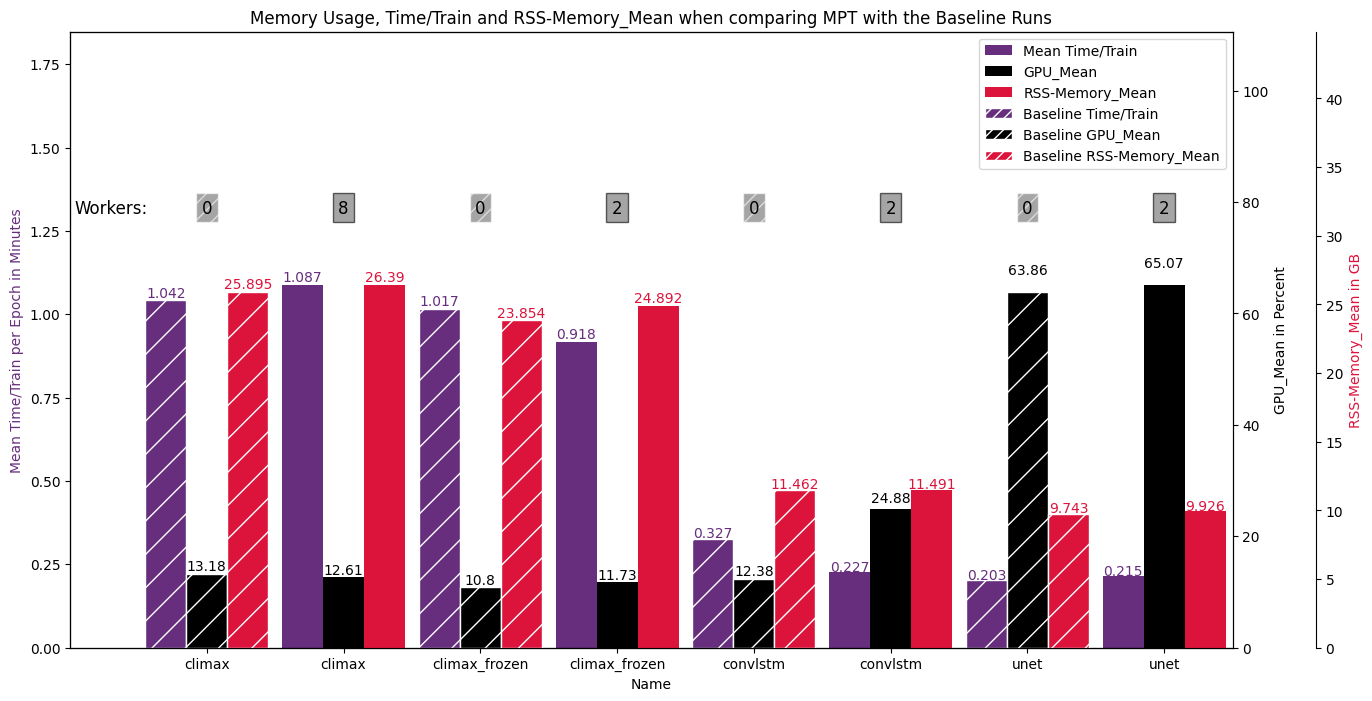

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your dataframe
df = merged_df_summary
print(df)

# Set up the plot
fig, ax1 = plt.subplots(figsize=(15, 8))
max_time_train = df['Time/Train Mean_Minutes'].max()
max_rss_memory = df['GPU_Mean'].max()
max_min_rmse = df['RSS-Memory_Mean'].max()
# Plot the Time/Train Mean_Minutes with dashed bars for Treatment == 2
ax1.set_xlabel('Name')
ax1.set_ylabel('Mean Time/Train per Epoch in Minutes', color='#662E7D')
bars1 = ax1.bar(df.index - 0.3, df['Time/Train Mean_Minutes'], width=0.3, label='Mean Time/Train per Epoch in Minutes', color='#662E7D')
for i, bar in enumerate(bars1):
    if int(df['Treatment'][i]) == 0:
        bar.set_hatch('/')
        bar.set_edgecolor("white")

# Create a second y-axis for RSS_Memory
ax2 = ax1.twinx()
ax2.set_ylabel('GPU_Mean in Percent', color='black')
bars2 = ax2.bar(df.index, df['GPU_Mean'], width=0.3, label='GPU_Mean', color='black')
for i, bar in enumerate(bars2):
    if int(df['Treatment'][i]) == 0:
        bar.set_hatch('/')
        bar.set_edgecolor("white")

# Create a third y-axis for RSS-Memory_Integral
ax3 = ax1.twinx()
# Move the third y-axis spine to the right
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('RSS-Memory_Mean in GB', color='crimson')
bars3 = ax3.bar(df.index + 0.3, df['RSS-Memory_Mean'], width=0.3, label='RSS-Memory_Mean in GB', color='crimson')
for i, bar in enumerate(bars3):
    if int(df['Treatment'][i]) == 0:
        bar.set_hatch('/')
        bar.set_edgecolor("white")

# Adding names as x-axis labels
ax1.set_xticks(df.index)
ax1.set_xticklabels(df['Name'])

# Annotate the bars with Treatment values
for i in range(len(df)):
    ax1.text(df.index[i] - 0.3, df['Time/Train Mean_Minutes'][i] * 1.01, str(df['Time/Train Mean_Minutes'][i]), ha='center', color='#662E7D',fontsize=10)
    ax2.text(df.index[i], df['GPU_Mean'][i]* 1.05, str(df['GPU_Mean'][i]), ha='center', color='black',fontsize=10)
    ax3.text(df.index[i] + 0.3, df['RSS-Memory_Mean'][i] * 1.01, str(df['RSS-Memory_Mean'][i]), ha='center', color='crimson')
    if df['Treatment'][i] == 0:
        if(i==0):
            ax1.text(df.index[i]- 0.7, max_time_train * 1.2, "Workers:", ha='center', color='black',fontsize=12)
        ax1.text(df.index[i], max_time_train * 1.2, int(df["Treatment"][i]), ha='center', color='black',fontsize=12, bbox=dict(facecolor='dimgray', alpha=0.6, hatch="//",edgecolor="white"))
    else:
        ax1.text(df.index[i], max_time_train * 1.2, int(df["Treatment"][i]), ha='center', color='black',fontsize=12, bbox=dict(facecolor='dimgray', alpha=0.6))

# Add legend with grouped labels
purple_patch = plt.Rectangle((0, 0), 1, 1, fc="#662E7D", hatch="")
black_patch = plt.Rectangle((0, 0), 1, 1, fc="black", hatch="")
crimson_patch = plt.Rectangle((0, 0), 1, 1, fc="crimson", hatch="")
dashed_purple_patch = plt.Rectangle((0, 0), 1, 1, fc="#662E7D", edgecolor="white", hatch="///")
dashed_black_patch = plt.Rectangle((0, 0), 1, 1, fc="black", edgecolor="white", hatch="///")
dashed_crimson_patch = plt.Rectangle((0, 0), 1, 1, fc="crimson", edgecolor="white", hatch="///")

plt.legend(handles=[purple_patch, black_patch, crimson_patch, dashed_purple_patch, dashed_black_patch, dashed_crimson_patch],
           labels=['Mean Time/Train', 'GPU_Mean','RSS-Memory_Mean', 'Baseline Time/Train', 'Baseline GPU_Mean','Baseline RSS-Memory_Mean'], loc='upper right')

# Adjust y-axis limits to add more whitespace upwards


ax1.set_ylim(0, max_time_train * 1.7)
ax2.set_ylim(0, max_rss_memory * 1.7)
ax3.set_ylim(0, max_min_rmse * 1.7)
ax1.set_xlim(df.index[0] - 1, df.index[-1] + 0.5)

plt.title('Memory Usage, Time/Train and RSS-Memory_Mean when comparing MPT with the Baseline Runs')
# Set x-tick and y-tick label sizes
# Save the figure
fig.savefig("figures/RQ_2.5_combined_bar/RQ_2.5_combined_bar.png")

# Show plot
plt.show()

